In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/training_set.csv'

Mounted at /content/drive


In [ ]:
import pandas as pd
df_columns=['target','id','date','flag','user','text']
dataset = pd.read_csv(file_path,
                 encoding='ISO-8859-1',
                 names=df_columns)
dataset.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
dataset.drop(['id','flag', 'user'], axis=1, inplace=True)

In [ ]:
dataset['target'] = dataset['target'].replace(4,1)

In [ ]:
neg_tweets = dataset[dataset['target'] == 0]
pos_tweets = dataset[dataset['target'] == 1]

neg_tweets_sub = neg_tweets.sample(150000,random_state = 20128)
pos_tweets_sub = pos_tweets.sample(150000,random_state = 20128)

new_dataset = pd.concat([neg_tweets_sub, pos_tweets_sub])

In [ ]:
import re
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
new_dataset['text'] = new_dataset['text'].apply(lambda x: cleaning_URLs(x))

new_dataset['text'] = new_dataset['text'].apply(lambda x: re.sub(r"@[\w]*", "", x))


df_dirty = new_dataset.copy()


new_dataset['text']=new_dataset['text'].str.lower()

new_dataset['text'] = new_dataset['text'].apply(lambda x: re.sub(r'[0-9]+', '', x))

new_dataset['text'] = new_dataset['text'].str.replace("[^a-zA-Z#]", " ", regex=True)

new_dataset['text'] = new_dataset['text'].apply(lambda x: " ".join([w for w in x.split() if len(w)>=3]))


df_lstm = new_dataset.copy()

# <font color=green>Transformers Based Approach - DistilBert Model



DistilBERT is a streamlined version of BERT, designed to efficiently capture complex patterns in the data. Its architecture, based on a transformer model, is excellent at processing sequences of words and understanding how words relate in context. This ability to understand subtle contextual information gives DistilBERT an edge over traditional neural and machine learning models, which might struggle with the intricacies of language.

The compression of BERT into DistilBERT makes the learning process more efficient. It retains the powerful capabilities of BERT while reducing the computational resources needed. This balance between performance and efficiency makes DistilBERT a great fit for various natural language processing tasks, as demonstrated by its impressive accuracy in this classification problem

In [ ]:
%%capture
!pip install datasets
!pip install umap-learn
!pip install transformers[torch] -U

In [ ]:
df_dirty.head()

,target,date,text
148479,0,Fri May 22 08:05:18 PDT 2009,this link doesnt work!!
741760,0,Sun Jun 21 08:21:55 PDT 2009,"Mmmm, fruit salad. I don't like watermelon muc..."
739380,0,Sun Jun 21 07:09:40 PDT 2009,my frnds arent letting me watch d match n som...
612811,0,Thu Jun 18 10:19:49 PDT 2009,kind of now yeah :-/ i had some more strawber...
338052,0,Wed Jun 03 01:12:59 PDT 2009,Should have stated TUES 26 MAY 22.35 - check-...


In [ ]:
dati = {
    "text": df_dirty["text"],
    "label": df_dirty["target"]
}

Here we are splitting the dataset into training, validation, and test sets using the `train_test_split` method. In particular we chose to select the 70% of our dataset as training, the 15% as validation and the remain 15% as test.

In [ ]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

dataset_bert = Dataset.from_dict(dati)

train_percent = 0.7
validation_percent = 0.15
test_percent = 0.15

# split the dataset
splits = dataset_bert.train_test_split(test_size=1 - train_percent)

# calculate the actual percentage for validation and test
remaining_percent = 1 - train_percent
validation_actual_percent = validation_percent / remaining_percent
test_actual_percent = test_percent / remaining_percent

# split the temporary dataset into validation and test sets
splits_validation_test = splits["test"].train_test_split(test_size=test_actual_percent)


dataset_dict = DatasetDict({
    "train": splits["train"],
    "validation": splits_validation_test["train"],
    "test": splits_validation_test["test"]
})

dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 209999
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 45000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 45001
    })
})

The **DistilBERT** has as maximum context size 512 tokens. Let's check the size of our words per tweet.

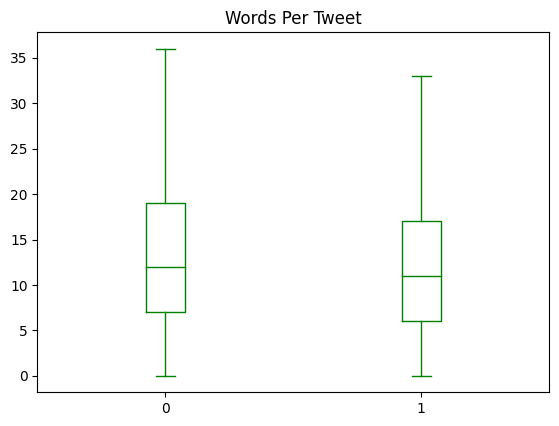

In [ ]:
import matplotlib.pyplot as plt
df_dirty["Words Per Tweet"] = df_dirty["text"].str.split().apply(len)
df_dirty.boxplot("Words Per Tweet", by="target", grid=False, showfliers=False,
           color="green")
plt.suptitle("")
plt.xlabel("")
plt.show()

Most tweets are around 12 words long and the longest tweets are well below DistilBERT's maximum context size.

This tokenization function uses the DistilBERT tokenizer to convert the text into tokens, while also handling padding and truncation to fit the model's requirements.

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

The code performs text tokenization for each batch in the dataset using the tokenize function. Tokenization occurs in parallel to improve efficiency. The output is a new dataset called dataset_encoded, where the text has been replaced with numerical representations (embeddings) obtained through tokenization with the DistilBERT tokenizer.

In [ ]:
dataset_encoded = dataset_dict.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/209999 [00:00<?, ? examples/s]

Map:   0%|          | 0/45000 [00:00<?, ? examples/s]

Map:   0%|          | 0/45001 [00:00<?, ? examples/s]

The code below specifies the model checkpoint name (in this case, `distilbert-base-uncased`) and determines whether a GPU (CUDA) is available. If the GPU is available, the model will be moved to the GPU, otherwise it will remain on the CPU.

In [ ]:
from transformers import AutoModel
import torch
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

This code uses the `Hugging Face Transformers` library to load a pre-trained DistilBERT model for binary sequence classification. Here's a detailed explanation:

In [ ]:
from transformers import AutoModelForSequenceClassification

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = 2
model_ft = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This function is designed to be used as an evaluation metric during the training of classification models. It calculates accuracy and F1 score by comparing the actual labels with the model's predictions.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

This code configures the training arguments for fine-tuning a pre-trained model using the `Hugging Face Transformers `library

In [ ]:
from transformers import Trainer, TrainingArguments

# configure training arguments
batch_size = 128

logging_steps = len(dataset_encoded["train"]) // batch_size

model_name = f"{model_ckpt}-finetuned-dataset_dict"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

This code encapsulates the training logic, leveraging the Trainer class from Hugging Face Transformers to streamline the training process with pre-defined configurations and datasets.

In [ ]:
from transformers import Trainer

# create the Trainer with the model, training arguments and the reduced dataset
trainer = Trainer(
    model=model_ft,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["validation"],
    tokenizer=tokenizer
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.394700,0.363047,0.838556,0.838348
2,0.328200,0.355563,0.844022,0.844020


TrainOutput(global_step=3282, training_loss=0.3613825017980219, metrics={'train_runtime': 2053.2731, 'train_samples_per_second': 204.55, 'train_steps_per_second': 1.598, 'total_flos': 1.869023302758653e+16, 'train_loss': 0.3613825017980219, 'epoch': 2.0})

In [ ]:
preds_output = trainer.predict(dataset_encoded["validation"])

In [ ]:
preds_output.metrics

{'test_loss': 0.35556283593177795,
 'test_accuracy': 0.8440222222222222,
 'test_f1': 0.8440196436402598,
 'test_runtime': 98.0785,
 'test_samples_per_second': 458.816,
 'test_steps_per_second': 3.589}

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix_db = confusion_matrix(preds_output.predictions.argmax(axis=1),preds_output.label_ids)

<Axes: >

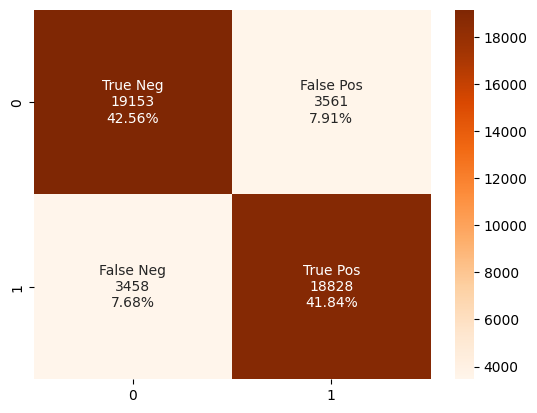

In [ ]:
import numpy as np
import seaborn as sns
group_names_db = ['True Neg','False Pos','False Neg','True Pos']
group_counts_db = ["{0:0.0f}".format(value) for value in
                cf_matrix_db.flatten()]
group_percentages_db = ["{0:.2%}".format(value) for value in
                     cf_matrix_db.flatten()/np.sum(cf_matrix_db)]
labels_db = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names_db,group_counts_db,group_percentages_db)]
labels_db = np.asarray(labels_db).reshape(2,2)
sns.heatmap(cf_matrix_db, annot=labels_db, fmt='', cmap='Oranges')

# <font color=green>Comparison among our "best" models


The DistilBERT model achieved an impressive accuracy of 84%, outperforming the best neural model at 78% and the top-performing machine learning model at 76%. This outstanding performance is due to DistilBERT's unique strengths.

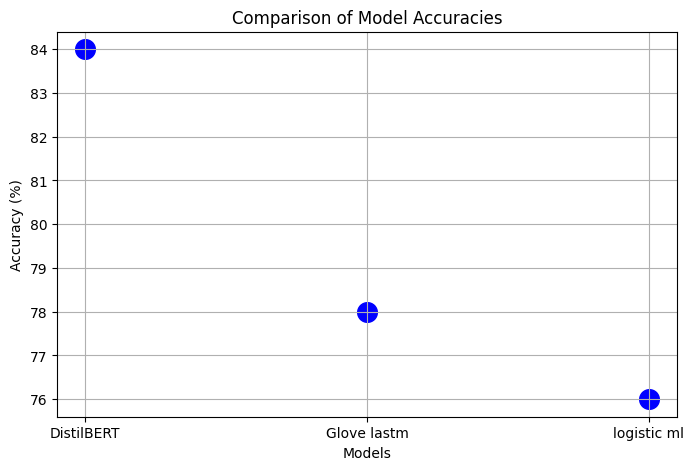

In [ ]:
import matplotlib.pyplot as plt

models = ['DistilBERT', 'Glove lastm', 'logistic ml']
accuracies = [84, 78, 76]

plt.figure(figsize=(8, 5))
plt.scatter(models, accuracies, color='blue', marker='o', s=200)

plt.title('Comparison of Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.show()

As we can see from the graph, the model trained with DistilBERT exhibits significantly better accuracy compared to traditional machine learning and neural network models. This, as mentioned earlier, can be explained by three factors:



*   Bidirectional Encoding: BERT uses a bidirectional approach for encoding text sequences. This means it can consider the context both to the left and right of a word in a sentence, capturing more complex relationships and improving context understanding.
*   Context Awareness: Thanks to self-attention, BERT can simultaneously consider all the words in a sequence, assigning different weights to each word based on the context. This allows it to capture richer semantic relationships.
*   Pre-training on Large Datasets: BERT is pretrained on massive amounts of data, enabling it to learn generic linguistic representations that can be transferred to specific tasks with limited training data.

